In [1]:
from solver_selection_thm.pp_binding import SolverSelectionMixinTHM
from pathlib import Path
import porepy as pp
import numpy as np
from thermal.thermal_runscript_5 import Physics, ConstraintLineSearchNonlinearSolver, Geometry
from plot_utils import write_dofs_info
from stats import StatisticsSavingMixin

XMAX = 1000
YMAX = 2000
ZMAX = 1000


class Setup(Geometry, SolverSelectionMixinTHM, StatisticsSavingMixin, Physics):
    def simulation_name(self) -> str:
        name = "stats_solver_selection"
        setup = self.params["setup"]
        name = f'{name}_geo{setup["geometry"]}x{setup["grid_refinement"]}'
        return name

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
def make_model(setup: dict):
    cell_size_multiplier = setup["grid_refinement"]

    DAY = 24 * 60 * 60

    shear = 1.2e10
    lame = 1.2e10
    if setup["steady_state"]:
        biot = 0
        dt_init = 1e0
        end_time = 1e1
    else:
        biot = 0.47
        dt_init = 1e-3
        end_time = 365 * 30
    porosity = 1.3e-2  # probably on the low side

    params = {
        "setup": setup,
        "folder_name": "visualization_3d",
        "material_constants": {
            "solid": pp.SolidConstants(
                # IMPORTANT
                permeability=1e-13,  # [m^2]
                residual_aperture=1e-3,  # [m]
                # LESS IMPORTANT
                shear_modulus=shear,  # [Pa]
                lame_lambda=lame,  # [Pa]
                dilation_angle=5 * np.pi / 180,  # [rad]
                normal_permeability=1e-6,
                # granite
                biot_coefficient=biot,  # [-]
                density=2683.0,  # [kg * m^-3]
                porosity=porosity,  # [-]
                friction_coefficient=0.577,  # [-]
                # Thermal
                specific_heat_capacity=720.7,
                thermal_conductivity=0.1,  # Diffusion coefficient
                thermal_expansion=9.66e-6,
            ),
            "fluid": pp.FluidComponent(
                compressibility=4.559 * 1e-10,  # [Pa^-1], fluid compressibility
                density=998.2,  # [kg m^-3]
                viscosity=1.002e-3,  # [Pa s], absolute viscosity
                # Thermal
                specific_heat_capacity=4182.0,  # Вместимость
                thermal_conductivity=0.5975,  # Diffusion coefficient
                thermal_expansion=2.068e-4,  # Density(T)
            ),
            "numerical": pp.NumericalConstants(
                characteristic_displacement=2e0,  # [m]
            ),
        },
        "reference_variable_values": pp.ReferenceVariableValues(
            pressure=3.5e7,  # [Pa]
            temperature=273 + 120,
        ),
        "grid_type": "simplex",
        "time_manager": pp.TimeManager(
            dt_init=dt_init * DAY,
            schedule=[0, end_time * DAY],
            iter_max=10,
            constant_dt=False,
            recomp_max=1,
        ),
        "units": pp.Units(kg=1e10),
        "meshing_arguments": {
            "cell_size": (0.1 * XMAX / cell_size_multiplier),
            "cell_size_boundary": (0.25 * XMAX / np.sqrt(cell_size_multiplier)),
        },
        # "refinement_level": cell_size_multiplier,
        # experimental
        "adaptive_indicator_scaling": 1,  # Scale the indicator adaptively to increase robustness
    }
    return Setup(params)


def run_model(setup: dict):
    model = make_model(setup)
    model.prepare_simulation()
    print(model.simulation_name())

    pp.run_time_dependent_model(
        model,
        {
            "prepare_simulation": False,
            "progressbars": False,
            "nl_convergence_tol": float("inf"),
            "nl_convergence_tol_res": 1e-8,
            "nl_divergence_tol": 1e8,
            "max_iterations": 10,
            # experimental
            "nonlinear_solver": ConstraintLineSearchNonlinearSolver,
            "Global_line_search": 1,  # Set to 1 to use turn on a residual-based line search
            "Local_line_search": 1,  # Set to 0 to use turn off the tailored line search
        },
    )

    write_dofs_info(model)
    print(model.simulation_name())

In [3]:
from solver_selection_thm.solver_space import CategoricalChoices, NumericalChoices


contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]


def make_solver_space_scheme_fthm(nd: int):
    return {
        "block_type": "LinearTransformedScheme",
        "scale_energy_balance": True,
        "Qright": True,
        "inner": {
            "block_type": "PetscKSPScheme",
            "petsc_options": {
                "ksp_monitor": None,
                "ksp_rtol": 1e-12,
            },
            "compute_eigenvalues": False,
            "preconditioner": {
                "block_type": "PetscFieldSplitScheme",
                "groups": contact,
                "block_size": nd,
                "fieldsplit_options": {
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                "elim_options": {
                    "pc_type": "pbjacobi",
                },
                "keep_options": {
                    "mat_schur_complement_ainv_type": "blockdiag",
                },
                "complement": {
                    "block_type": "PetscFieldSplitScheme",
                    "groups": intf,
                    "elim_options": {
                        "pc_type": "ilu",
                    },
                    "fieldsplit_options": {
                        "pc_fieldsplit_schur_precondition": "selfp",
                    },
                    "complement": {
                        "block_type": "PetscFieldSplitScheme",
                        "groups": mech,
                        "elim_options": CategoricalChoices(
                            [
                                {
                                    "pc_type": "hmg",
                                    "hmg_inner_pc_type": "hypre",
                                    "hmg_inner_pc_hypre_type": "boomeramg",
                                    "hmg_inner_pc_hypre_boomeramg_strong_threshold": NumericalChoices([0.5, 0.6, 0.7, 0.8]),
                                    "mg_levels_ksp_type": CategoricalChoices(['chebyshev', 'richardson']),
                                    "mg_levels_ksp_max_it": NumericalChoices([1, 2, 4, 8]),
                                    "mg_levels_pc_type": CategoricalChoices(['ilu', 'sor']),
                                },
                            ]
                        ),
                        "block_size": nd,
                        "invert": {
                            "block_type": "fs_analytical_slow_new",
                            "p_mat_group": 5,
                            "p_frac_group": 6,
                            "groups": flow + temp,
                        },
                        "complement": {
                            "block_type": CategoricalChoices(
                                [
                                    {
                                        "block_type": "PetscFieldSplitScheme",
                                        "groups": flow + temp,
                                        "python_pc": {
                                            "block_type": "PcPythonPermutation",
                                            "permutation_type": "pt_permutation",
                                            "p_groups": flow,
                                            "t_groups": temp,
                                            "block_size": 2,
                                        },
                                        "elim_options": {
                                            "python_pc_type": "hypre",
                                            "python_pc_hypre_type": "boomeramg",
                                            "python_pc_hypre_boomeramg_strong_threshold": NumericalChoices([0.5, 0.6, 0.7, 0.8]),
                                            "python_pc_hypre_boomeramg_P_max": 16,
                                        },
                                    },
                                    {
                                        "block_type": "PetscCompositeScheme",
                                        "groups": flow + temp,
                                        "solvers": {
                                            0: {
                                                "block_type": "PetscFieldSplitScheme",
                                                "groups": flow,
                                                "fieldsplit_options": {
                                                    "pc_fieldsplit_type": "additive",
                                                },
                                                "elim_options": {
                                                    "pc_type": "hypre",
                                                    "pc_hypre_type": "boomeramg",
                                                    "pc_hypre_boomeramg_strong_threshold": NumericalChoices([0.5, 0.6, 0.7, 0.8]),
                                                },
                                                "complement": {
                                                    "block_type": "PetscFieldSplitScheme",
                                                    "groups": temp,
                                                    "elim_options": {
                                                        "pc_type": "none",
                                                    },
                                                },
                                            },
                                            1: {
                                                "block_type": "PetscFieldSplitScheme",
                                                "groups": flow + temp,
                                                "python_pc": {
                                                    "block_type": "PcPythonPermutation",
                                                    "permutation_type": "pt_permutation",
                                                    "p_groups": flow,
                                                    "t_groups": temp,
                                                    "block_size": 2,
                                                },
                                                "elim_options": {
                                                    "python_pc_type": "ilu",
                                                },
                                            },
                                        },
                                    },
                                ]
                            ),
                        },
                    },
                },
            },
        },
    }

In [4]:
from solver_selection_thm.performance_predictor import PerformancePredictorEpsGreedy, RewardEstimator
from solver_selection_thm.selector import SolverSelector
from solver_selection_thm.solver_space import SolverSpace
from solver_selection_thm.pp_binding import KNOWN_SOLVER_COMPONENTS_THM


solver_space = SolverSpace(
        solver_space_scheme=make_solver_space_scheme_fthm(nd=3),
        solver_scheme_builders=KNOWN_SOLVER_COMPONENTS_THM,
    )
num_solvers = solver_space.all_decisions_encoding.shape[0]
performance_predictor = PerformancePredictorEpsGreedy(
    num_solvers=num_solvers,
    exploration=0.5,
    exploration_decrease_rate=0.9,
)
solver_selector = SolverSelector(
    reward_estimator=RewardEstimator(),
    solver_space=solver_space,
    performance_predictor=performance_predictor,
)
print(solver_space.decision_tree)

block_type: LinearTransformedScheme
| elim_options (fork with 1 branches):
| | pc_type: hmg
| | | hmg_inner_pc_hypre_boomeramg_strong_threshold: Choices from 0.5 to 0.8, len = 4
| | | mg_levels_ksp_max_it: Choices from 1 to 8, len = 4
| | | mg_levels_ksp_type (fork with 2 branches):
| | | | chebyshev
| | | | richardson
| | | mg_levels_pc_type (fork with 2 branches):
| | | | ilu
| | | | sor
| block_type (fork with 2 branches):
| | block_type: PetscFieldSplitScheme
| | | python_pc_hypre_boomeramg_strong_threshold: Choices from 0.5 to 0.8, len = 4
| | block_type: PetscCompositeScheme
| | | pc_hypre_boomeramg_strong_threshold: Choices from 0.5 to 0.8, len = 4


In [5]:
common_params = {
    "geometry": "5",
    "save_matrix": False,
    "grid_refinement": 0.25,
    "linear_solver_selector": solver_selector,
    "solver": "ignore_me_please",
}

print("Running steady state")
params = {
    "steady_state": True,
} | common_params
run_model(params)
end_state_filename = params["end_state_filename"]
# end_state_filename = '/home/porepy/volume/nrec_fhm/stats_thermal_geo5x2_solFGMRES_endstate_1743628386898.npy'



Running steady state

stats_solver_selection_geo5x0.25

Sim time: 1.00e+00, Dt: 1.00e+00 (days)
Temperature: 393.00, 393.00
Peclet: 0.0e+00, CFL: 2.0e-16
sticking: 127, sliding: 0, open: 0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Construction took: 1.61
  0 KSP Residual norm 4.647148570617e+03 
  1 KSP Residual norm 2.945449068735e+02 
  2 KSP Residual norm 1.089181546443e+02 
  3 KSP Residual norm 2.277475990091e+01 
  4 KSP Residual norm 4.802542826250e+00 
  5 KSP Residual norm 1.577142880750e+00 
  6 KSP Residual norm 4.957182997932e-01 
  7 KSP Residual norm 1.993474928286e-01 
  8 KSP Residual norm 4.655594632205e-02 
  9 KSP Residual norm 1.867536660091e-02 
 10 KSP Residual norm 7.422747632400e-03 
 11 KSP Residual norm 1.300140837035e-03 
 12 KSP Residual norm 2.897990046981e-04 
 13 KSP Residual norm 9.556749706816e-05 
 14 KSP Residual norm 2.764331013922e-05 
 15 KSP Residual norm 4.697631463973e-06 
 16 KSP Residual norm 4.853662497492e-07 
 17 KSP Residual norm 5.171838674089e-08 
 18 KSP Residual norm 4.303675950708e-09 
Solve took: 0.31
Newton iter: 0, Krylov iters: 19
Temperature: 393.00, 393.00
Peclet: 1.6e-09, CFL: 2.8e-14
Increment: 6.0e-01, residual: 5.0e-03
sticking: 103, sliding: 24, open

In [ ]:
print("Running injection")
params = {
    "steady_state": False,
    "initial_state": end_state_filename,
} | common_params
run_model(params)

Running injection

stats_solver_selection_geo5x0.25

Sim time: 1.00e-03, Dt: 1.00e-03 (days)
Temperature: 392.98, 403.41
Peclet: 1.1e-03, CFL: 5.8e-12
sticking: 103, sliding: 24, open: 0
Construction took: 0.34
  0 KSP Residual norm 3.345600020652e+00 
  1 KSP Residual norm 3.735503609717e-02 
  2 KSP Residual norm 1.564854176592e-02 
  3 KSP Residual norm 6.509593932317e-03 
  4 KSP Residual norm 2.040685078003e-03 
  5 KSP Residual norm 4.027612207988e-04 
  6 KSP Residual norm 3.775106396278e-05 
  7 KSP Residual norm 1.965849993271e-05 
  8 KSP Residual norm 9.173319825918e-06 
  9 KSP Residual norm 2.750578819035e-06 
 10 KSP Residual norm 1.071271430447e-06 
 11 KSP Residual norm 7.223842885352e-07 
 12 KSP Residual norm 3.397307459156e-07 
 13 KSP Residual norm 1.270322927436e-07 
 14 KSP Residual norm 5.405831515152e-08 
 15 KSP Residual norm 1.615389832826e-08 
 16 KSP Residual norm 3.136645834098e-09 
 17 KSP Residual norm 8.253598130243e-10 
 18 KSP Residual norm 1.724749736

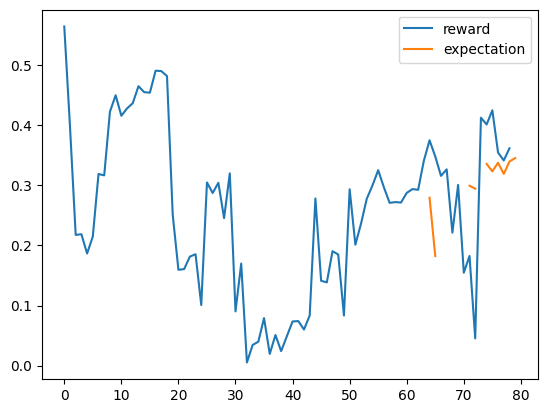

In [25]:
from matplotlib import pyplot as plt
plt.plot(solver_selector.history.reward, label='reward')
e = np.array(solver_selector.history.expectation)
e[e == 100] = np.nan
plt.plot(e, label='expectation')
plt.legend()

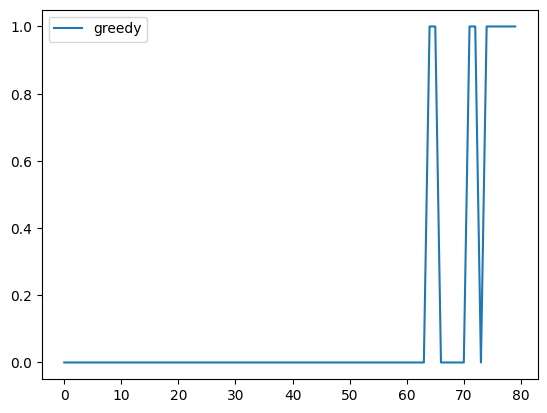

In [26]:
plt.plot(solver_selector.history.greedy, label='greedy')
plt.legend()